In [1]:
import numpy as np
import matplotlib.pyplot as plt # para plots
import torch as tc
import pandas as pd
import torch.nn as nn

In [2]:

# Função que define a equação diferencial
def EDO_pendulo(t, y):
    theta, d_theta_dt = y
    dd_theta_dt = - (g / L) * np.sin(theta)
    return [d_theta_dt, dd_theta_dt]

def generate_data_set(omega = 1, theta = 0, time_parameters =[] ):
    t_0,t_end,dt = time_parameters    
    # Método de Euler para resolver a EDO
    t_values = np.arange(t_0, t_end, dt)

    theta_values = []
    omega_values = []
    for t in t_values:
        theta_values.append(theta)
        omega_values.append(omega)
        
        # Método de Euler
        dtheta_dt, domega_dt = EDO_pendulo(t, [theta, omega])
        theta += dtheta_dt * dt
        omega += domega_dt * dt

    # Converter o deslocamento angular para coordenadas x-y
    x_values = L * np.sin(theta_values)
    y_values = -L * np.cos(theta_values)
    return [x_values,y_values]

def plot_Pendulum(data):
    x_values, y_values = data 
    # Plotagem
    plt.plot(x_values, y_values)
    plt.xlabel('x (t)')
    plt.ylabel('y (t)')
    plt.title('Movimento do Pêndulo Simples')
    plt.grid(True)
    plt.axis('equal')
    plt.show()      


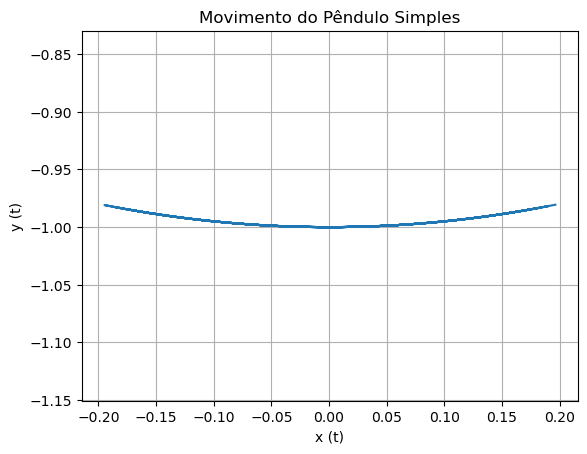

In [3]:
# Constantes
global g, L, phi, omega_0
g = 9.81  # m/s^2, aceleração devido à gravidade
L = 1.0   # m, comprimento do pêndulo
phi = np.pi / 2  # Ângulo inicial em radianos
omega_0 = 0.0        # Velocidade angular inicial

# Parâmetros de tempo
N=2000 # Numero de pontos
t_0 = 0.0            # Tempo inicial
t_end = 10.0         # Tempo final
dt = t_end/N            # Tamanho do passo de tempo
time_parameters = [t_0,t_end,dt]

# Condições iniciais
theta = phi 
omega = omega_0

data = generate_data_set(omega, theta, time_parameters)

plot_Pendulum(data[0:2])


Fazendo dataset de matrizes de imagem

In [4]:
import os
import matplotlib.colors as mcolors
from PIL import Image



def create_colormap():
    colors = ['blue', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list('blue_to_red', colors)
    return cmap


In [5]:

# Function to save dataset as images
def save_dataset_as_images(data_x, data_y, directory,trailsize = 10):
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Determine the number of frames based on the length of one of the data arrays
    num_frames = len(data_x)
    x_min, x_max = -1.3,1.3 #min(data_x), max(data_x)
    y_min, y_max = -2, 0.85, #min(data_y), max(data_y)
    # Loop through each frame in the dataset
    for i in range(num_frames):
        # Create a new figure
        plt.figure(figsize=(1,1))  # Adjust size as needed

        if i>trailsize:
            trail_x = data_x[i-trailsize:i]
            trail_y = data_y[i-trailsize:i]
        else:
            trail_x = data_x[0:i]
            trail_y = data_y[0:i]

        # Plot the points
        plt.scatter(trail_x, trail_y, s=5, c=np.arange(len(trail_x)), cmap=cmap)  # Adjust size as needed

        #plt.scatter(data_x[0:i], data_y[0:i], s=5, c='black')  # Adjust size and color as needed
        
        # Set plot limits if necessary
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Turn off axis
        plt.axis('off')
        
        # Save the figure as an image
        plt.savefig(os.path.join(directory, f'frame_{i:04d}.png'), bbox_inches='tight', pad_inches=0)
        
        # Close the figure to release memory
        plt.close()


In [6]:


data_x = data[0]  
data_y = data[1]  

# Directory to save images
output_directory = 'pendulum_images'

# Create a colormap from blue to red
cmap = create_colormap()
trailsize=100
# Save dataset as images
save_dataset_as_images(data_x, data_y, output_directory, trailsize)

print(f"Dataset saved as images in '{output_directory}' directory.")

In [8]:
frames_matrices = []

for i in range(len(data_x)):
    image_path = os.path.join(output_directory, f'frame_{i:04d}.png')
    image = Image.open(image_path)
    matrix = np.array(image)
    rgb_matrix = matrix[3:,3:,:3] # 376 to set image size 
    # Append the matrix for the current frame to the list
    frames_matrices.append(rgb_matrix)    

frames_matrices = np.array(frames_matrices)
frames_matrices_tensor = tc.tensor(frames_matrices, dtype=tc.float32)



(77, 77, 4)


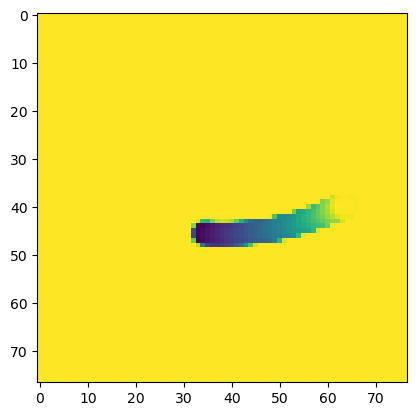

In [9]:
print(np.shape(matrix))

plt.imshow(matrix[:,:,0])

# Construindo uma CNN para analisar o data-set

In [10]:
def plot_input(img):
    image_np = img[0].numpy().transpose((1, 2, 0))
    
    # Plot each channel separately
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(3):
        axs[i].imshow(image_np[:, :, i], cmap='gray')  # Use cmap='gray' for grayscale images
        axs[i].set_title(f'Channel {i}')

    plt.show()

def plot_output(recon_img):
    img2 = recon_img[0].detach().numpy()
    image_np2 = img2.transpose((1, 2, 0))
    # Plot each channel separately
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i in range(3):
        axs[i].imshow(image_np2[:, :, i], cmap='gray')  # Use cmap='gray' for grayscale images
        axs[i].set_title(f'Channel {i}')

    plt.show()


In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, frames_matrices):
        self.frames_matrices = frames_matrices

    def __len__(self):
        return len(self.frames_matrices)

    def __getitem__(self, idx):
        image = self.frames_matrices[idx]
        # Assuming image is already normalized between 0 and 1
        image = tc.tensor(image, dtype=tc.float32)
        return image

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #nn.Linear(input_shape, input_shape),
            #nn.ReLU,
            nn.Conv2d(3, 18, 10, stride=2, padding=1),  # b, 16, 76, 76
            nn.MaxPool2d(kernel_size=10, stride=2),
            nn.ReLU,
            nn.Conv2d(18, 14, 4, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.ReLU,
            nn.Conv2d(14, 4, 3, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 4, 3, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        self.middlelayer = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps
            nn.Linear( 16, 32),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(32, 20),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(20, 32),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(32, 5),  # Dense layer with 5 neurons
            nn.Tanh(),
        )
        self.rnn = nn.LSTM(5, 20, 10)
        #self.rnn2 = nn.LSTM(25, 5, 13)
        self.middlelayer2 = nn.Sequential(
            nn.Linear(20,32),  # Dense layer with 50 neurons # MIDDLELAYER
            nn.Tanh(),
            #nn.Linear(5,32),  # Dense layer with 50 neurons # MIDDLELAYER
            #nn.Tanh(),
            nn.Linear(32, 20),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(20, 32),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(32,3 * 6 * 6),  # Dense layer with 50 neurons
            nn.Unflatten(1, (3, 6,6))  # Reshape back to feature maps
        )
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Upsample(scale_factor=3, mode='nearest'),
            nn.ConvTranspose2d(3, 16, 3, stride=2, padding=1, output_padding=1),  # b, 16, 76, 76
            nn.ReLU(),
            #nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 13, 8, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(),
            nn.ConvTranspose2d(13, 13, 4, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(),
            nn.ConvTranspose2d(13, 11, 3, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            nn.ReLU(),
            nn.ConvTranspose2d(11, 3, 2, stride=2, padding=1, output_padding=1),  # b, 3, 151, 151
            #nn.ReLU(),
            #nn.ConvTranspose2d(3, 3, 2, stride=2, padding=1, output_padding=1),
            #nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middlelayer(x)
        x = x.unsqueeze(0)
        x, _ = self.rnn(x)
        #x, _ = self.rnn2(x)
        x = x.squeeze(0)
        x = self.middlelayer2(x)
        x = self.decoder(x)
        return x


In [14]:
# Nova tentativa

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, frames_matrices):
        self.frames_matrices = frames_matrices

    def __len__(self):
        return len(self.frames_matrices)

    def __getitem__(self, idx):
        image = self.frames_matrices[idx]
        # Assuming image is already normalized between 0 and 1
        image = tc.tensor(image, dtype=tc.float32)
        return image

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #nn.Linear(input_shape, input_shape),
            #nn.ReLU(),
            nn.Conv2d(3, 77, 8, stride=2, padding=1),  # b, 16, 76, 76
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(77, 30, 5, stride=2, padding=1),  # b, 8, 38, 38
            nn.ReLU(),
            nn.Conv2d(30, 15, 5, stride=2, padding=1),  # b, 8, 38, 38
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),  # Flatten the feature maps
            nn.Linear(15, 180),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(180, 90),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(90, 45),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(45, 18),  # Dense layer with 5 neurons
            nn.Tanh(),
            nn.Linear(18,5),
            nn.Tanh()
        )
        self.middlelayer = nn.Sequential(
            nn.Linear(5,5),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 18),  # Dense layer with 5 neurons
            nn.Tanh(),
            nn.Linear(18, 45),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(45, 90),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(90, 180),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Linear(180, 16),  # Dense layer with 50 neurons
            nn.ReLU(),
            nn.Flatten(),  # Flatten the feature maps
            nn.Linear(16, 15 * 7 * 7),  # Dense layer with 50 neurons
            nn.ReLU(),
            #nn.Unflatten(1, (15, 27, 27)),  # Reshape back to feature maps
            nn.Unflatten(1, (15, 7, 7)),  # Reshape back to feature maps
            nn.ReLU(),
            nn.ConvTranspose2d(15, 30, 5, stride=2, padding=1, output_padding=1),  # b, 30, 77, 77
            nn.ReLU(),
            nn.ConvTranspose2d(30, 77, 8, stride=2, padding=1, output_padding=1),  # b, 77, 154, 154
            #nn.MaxPool2d(kernel_size=4, stride=3),
            nn.ReLU(),
            nn.ConvTranspose2d(77, 3, 3, stride=2, padding=1, output_padding=1),  # b, 3, 311, 311
            #nn.ReLU(),
            #nn.Flatten(),
            #nn.Linear(7700,77*77*3),
            #nn.Unflatten(1, (input_shape[2],input_shape[1],input_shape[1]))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middlelayer(x)
        x = self.decoder(x)
        return x


Epoch [1/200], Loss: 5176.9595


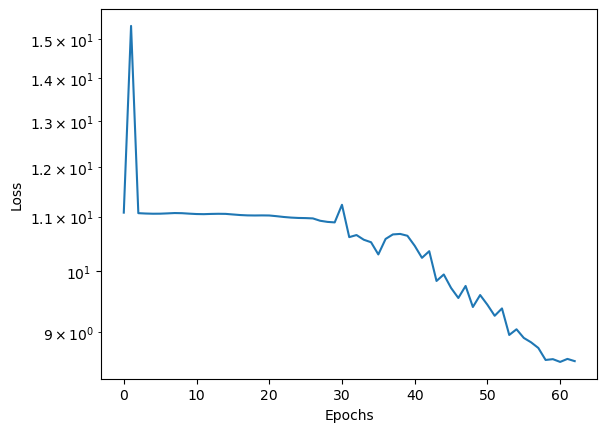

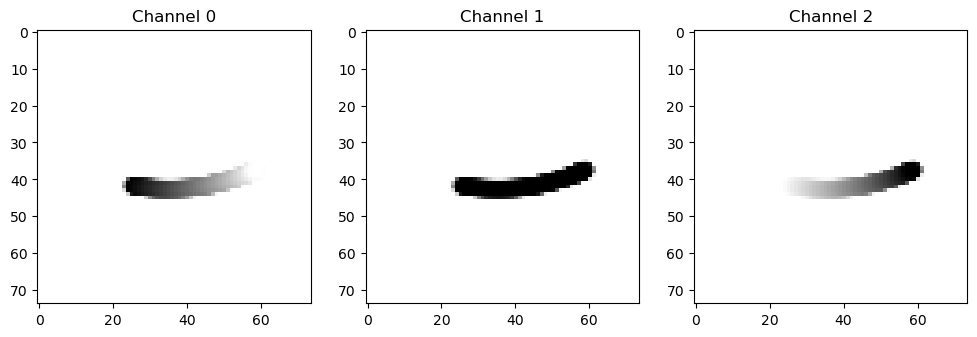

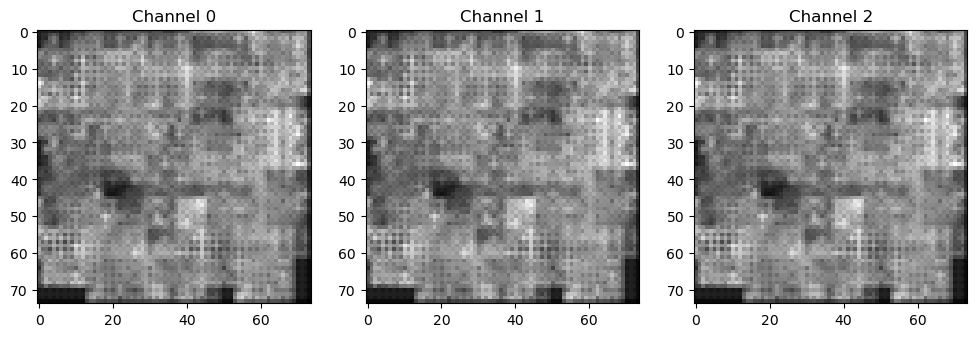

Epoch [2/200], Loss: 1148.8030
Epoch [3/200], Loss: 948.4153
Epoch [4/200], Loss: 887.4424
Epoch [5/200], Loss: 829.8579
Epoch [6/200], Loss: 821.8978


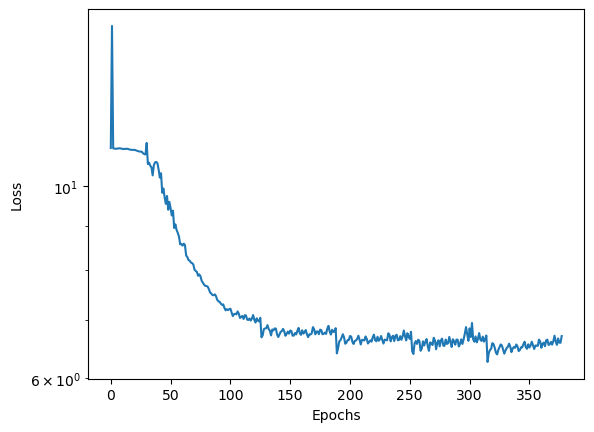

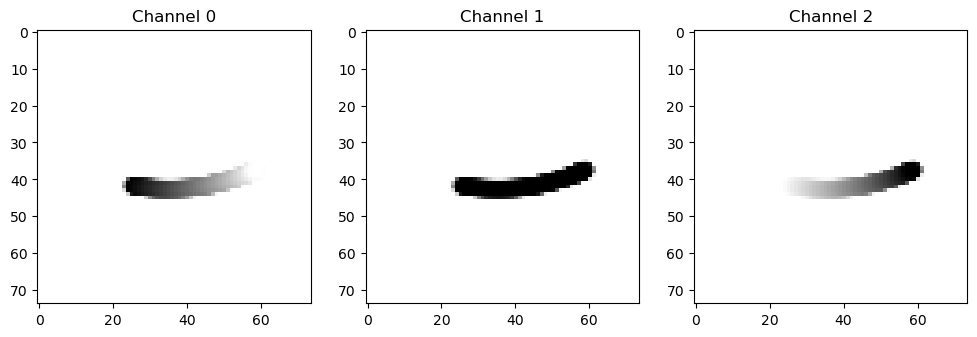

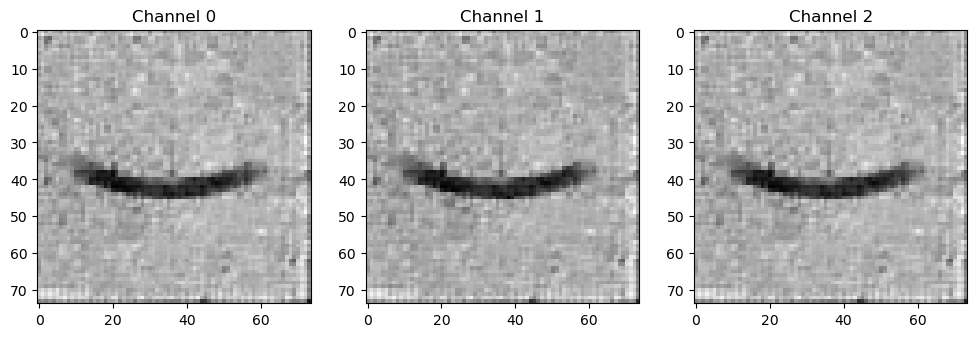

Epoch [7/200], Loss: 768.1353
Epoch [8/200], Loss: 752.5720
Epoch [9/200], Loss: 735.7660
Epoch [10/200], Loss: 731.3295
Epoch [11/200], Loss: 723.4362


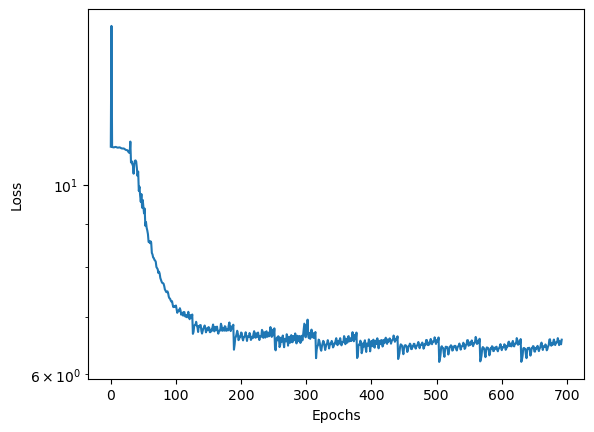

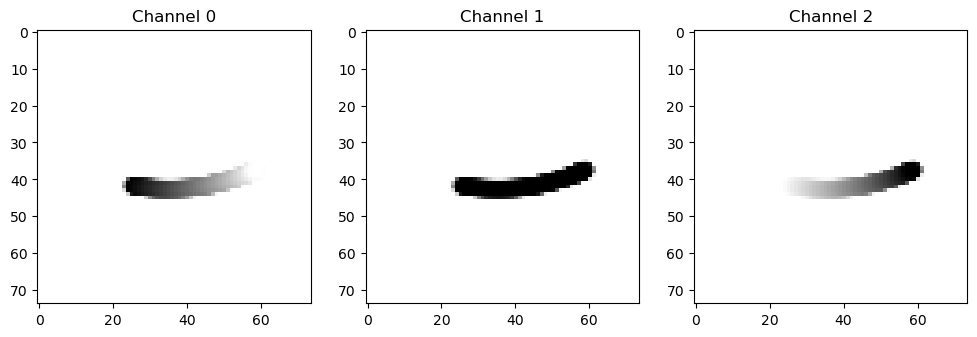

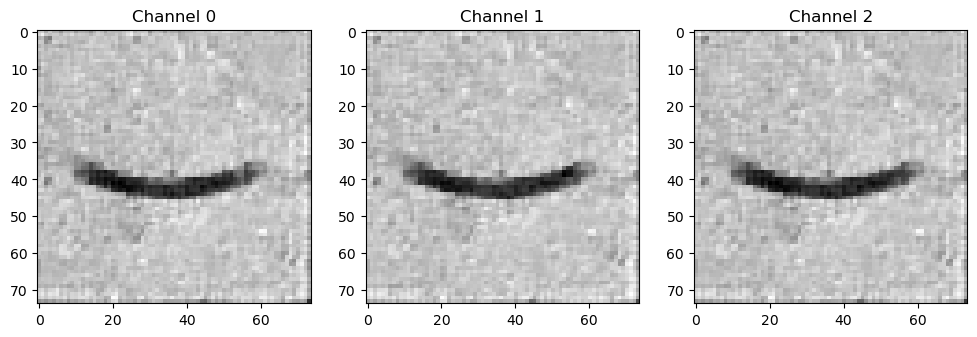

Epoch [12/200], Loss: 725.9266
Epoch [13/200], Loss: 704.9462
Epoch [14/200], Loss: 700.9291
Epoch [15/200], Loss: 729.8428
Epoch [16/200], Loss: 687.3667


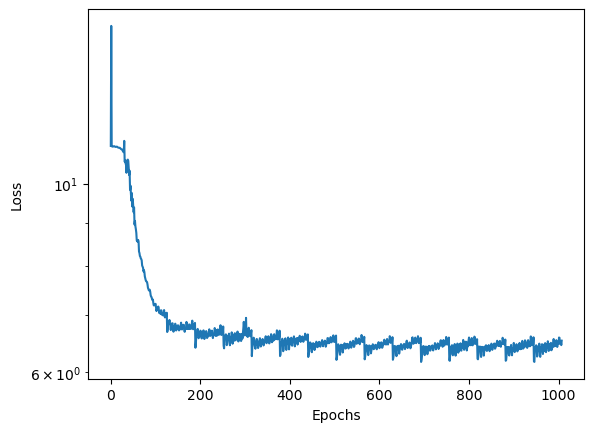

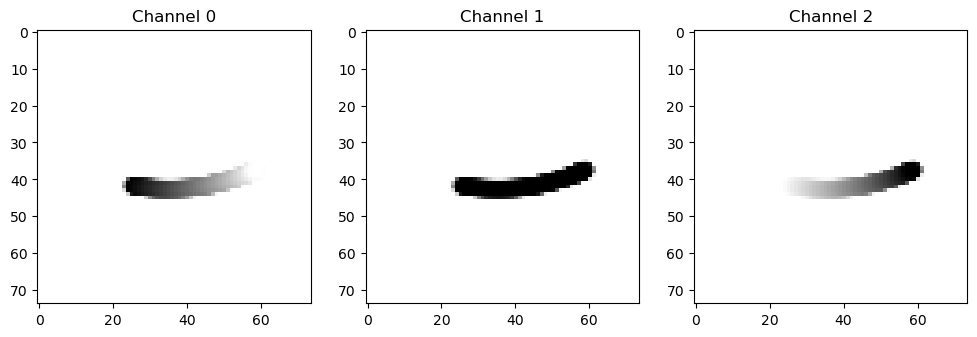

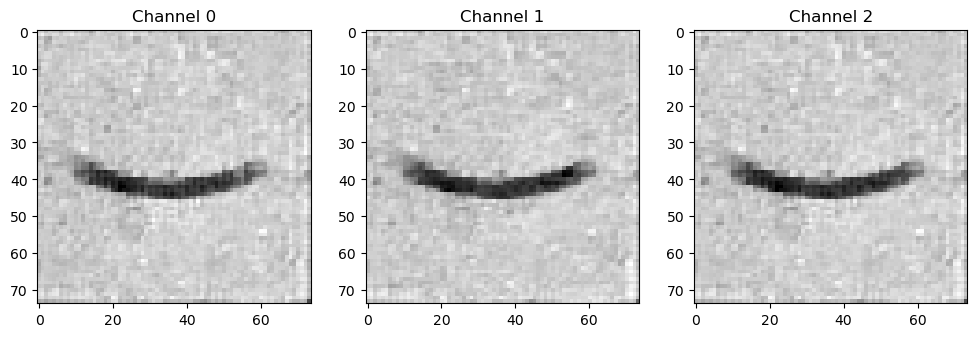

Epoch [17/200], Loss: 682.3139
Epoch [18/200], Loss: 697.3762
Epoch [19/200], Loss: 674.1405
Epoch [20/200], Loss: 705.5376
Epoch [21/200], Loss: 664.8810


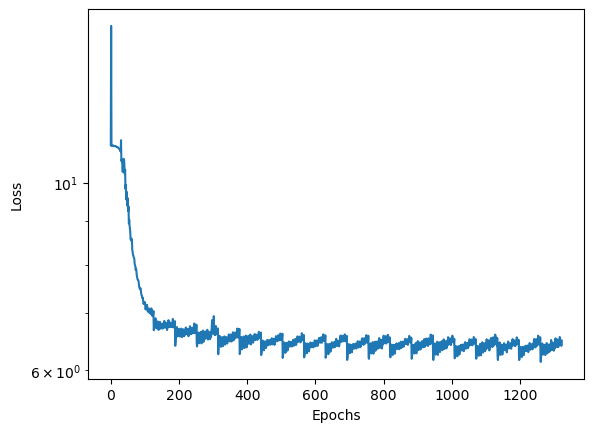

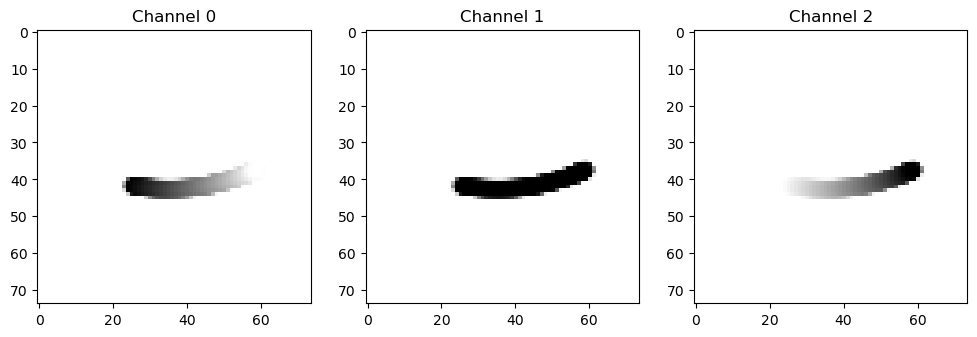

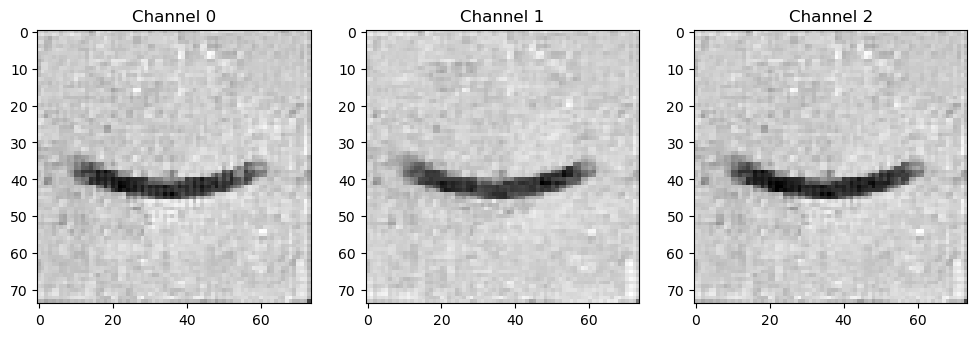

Epoch [22/200], Loss: 659.7969
Epoch [23/200], Loss: 671.8287
Epoch [24/200], Loss: 1113.3425
Epoch [25/200], Loss: 676.9033
Epoch [26/200], Loss: 643.3073


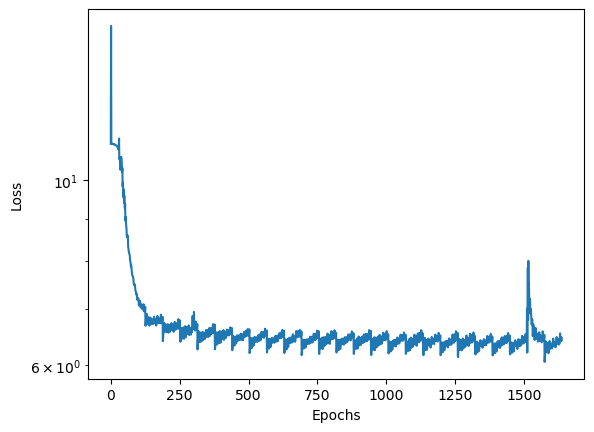

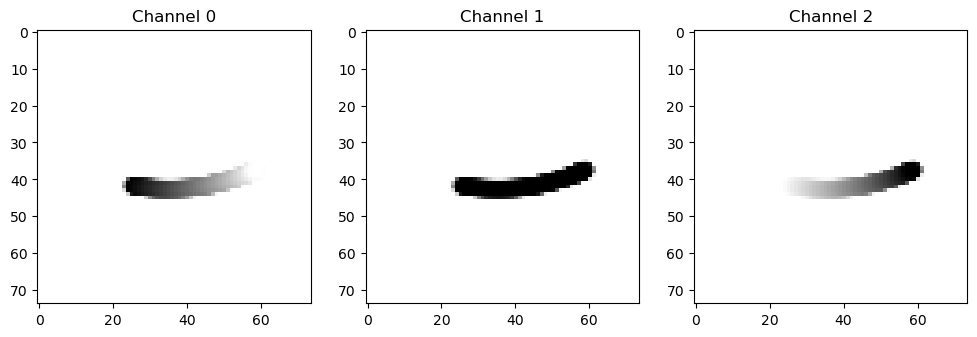

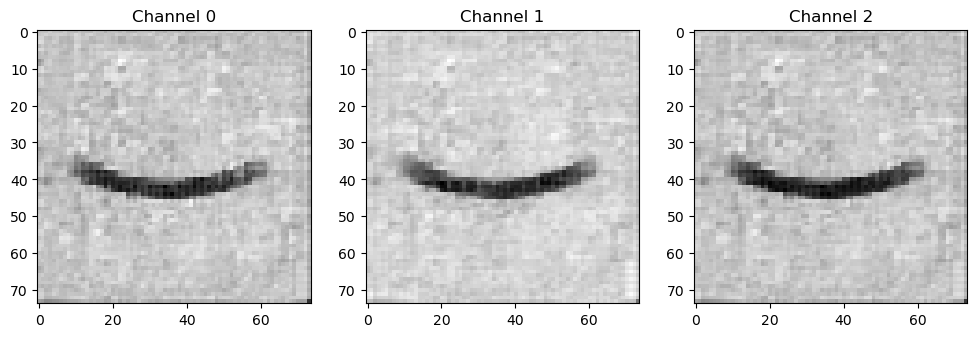

Epoch [27/200], Loss: 630.9395
Epoch [28/200], Loss: 626.3424
Epoch [29/200], Loss: 611.6711
Epoch [30/200], Loss: 613.5132
Epoch [31/200], Loss: 607.7242


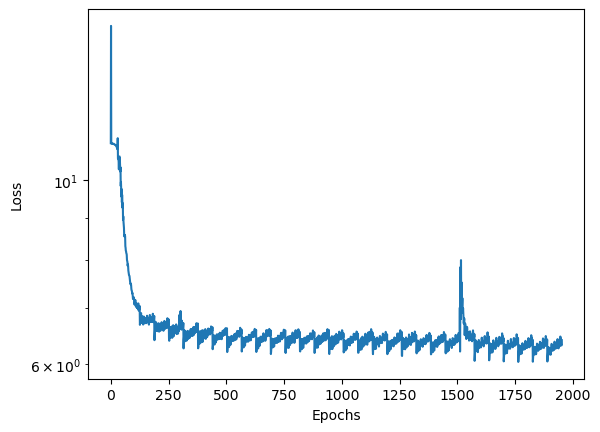

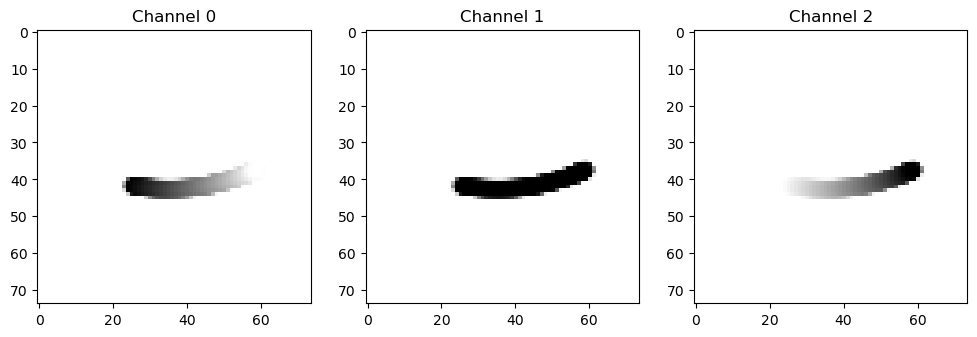

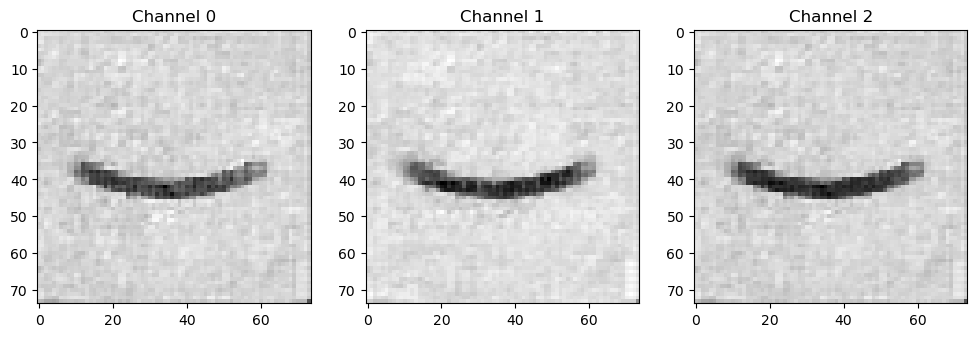

Epoch [32/200], Loss: 610.4566
Epoch [33/200], Loss: 626.1583
Epoch [34/200], Loss: 614.6020
Epoch [35/200], Loss: 603.0519
Epoch [36/200], Loss: 594.5223


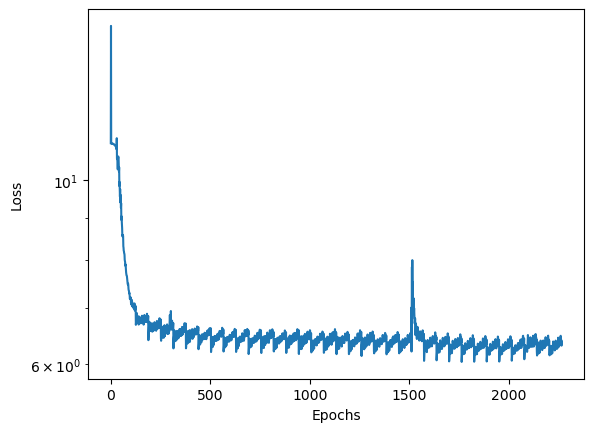

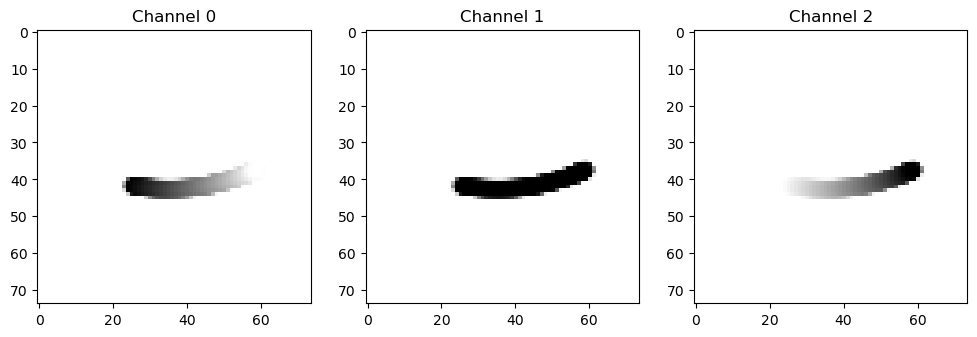

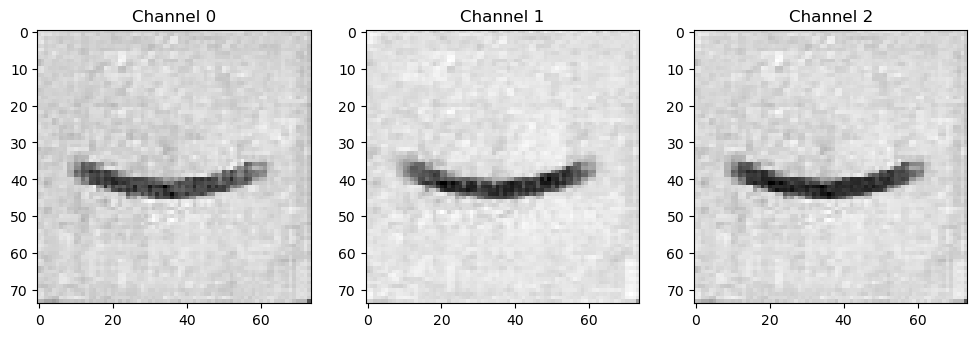

Epoch [37/200], Loss: 594.3130
Epoch [38/200], Loss: 594.7999
Epoch [39/200], Loss: 588.2789
Epoch [40/200], Loss: 589.3815
Epoch [41/200], Loss: 585.7191


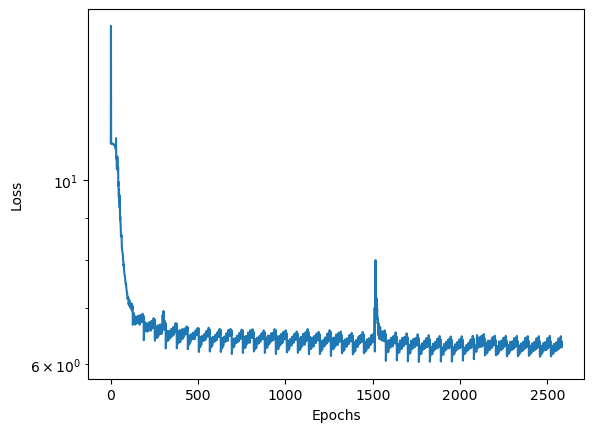

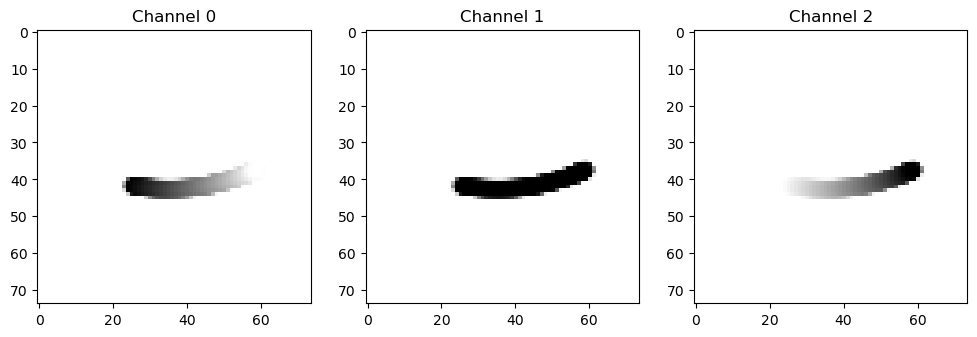

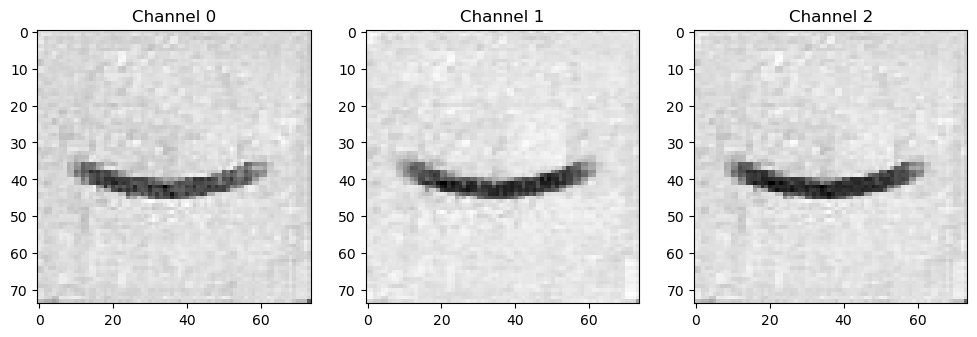

Epoch [42/200], Loss: 592.8548
Epoch [43/200], Loss: 604.0161
Epoch [44/200], Loss: 587.9590
Epoch [45/200], Loss: 582.9931
Epoch [46/200], Loss: 582.1916


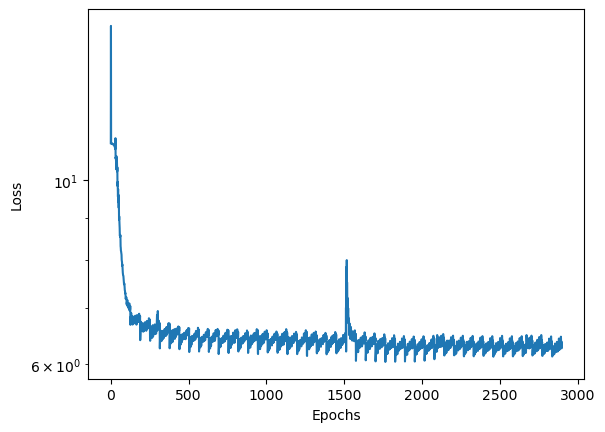

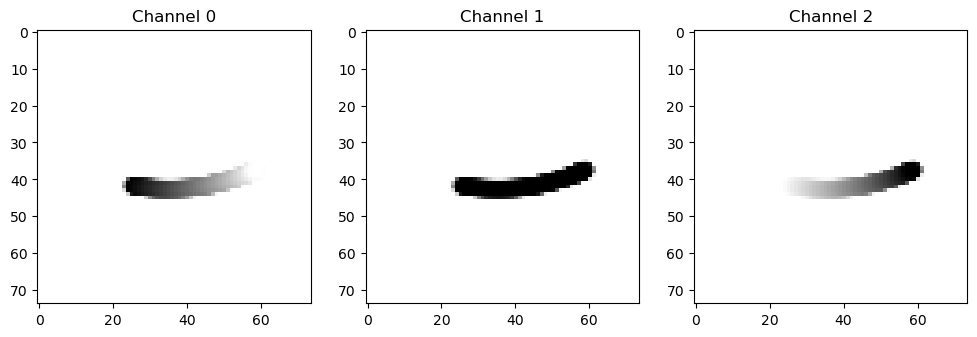

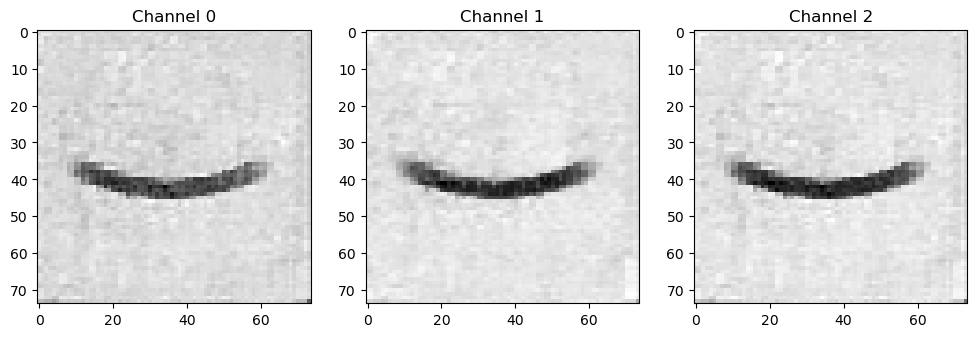

Epoch [47/200], Loss: 581.7539
Epoch [48/200], Loss: 583.5327
Epoch [49/200], Loss: 585.6382
Epoch [50/200], Loss: 581.8148
Epoch [51/200], Loss: 577.0281


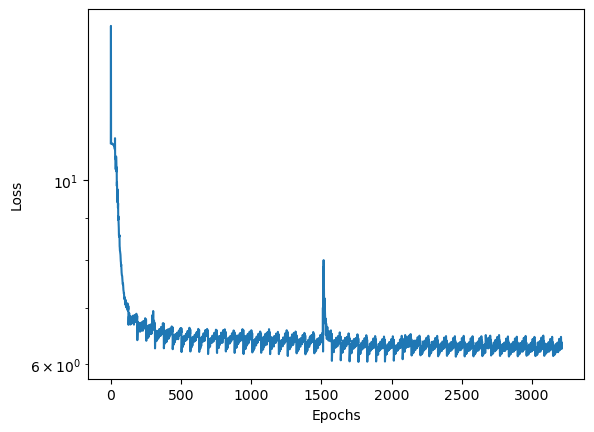

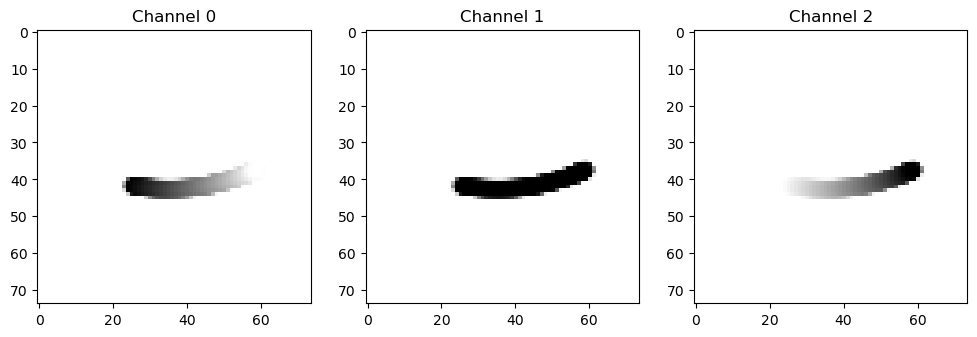

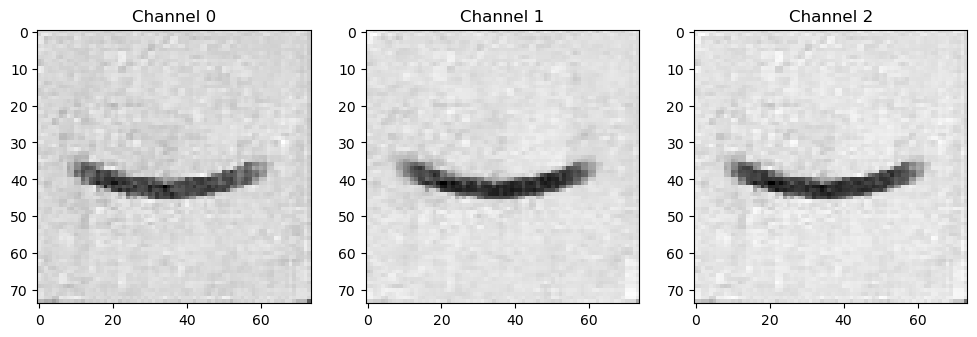

Epoch [52/200], Loss: 576.8847
Epoch [53/200], Loss: 584.5645
Epoch [54/200], Loss: 704.4104
Epoch [55/200], Loss: 621.6484
Epoch [56/200], Loss: 600.6481


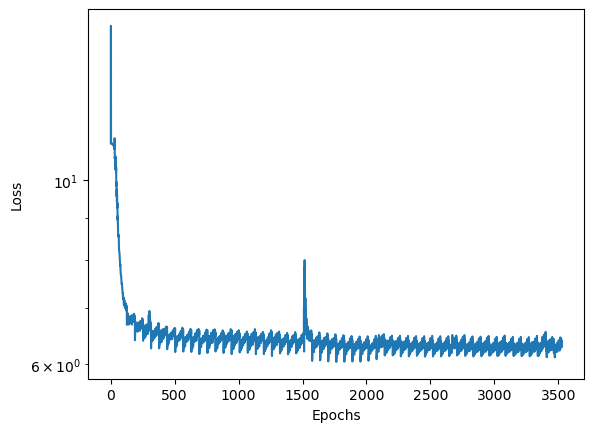

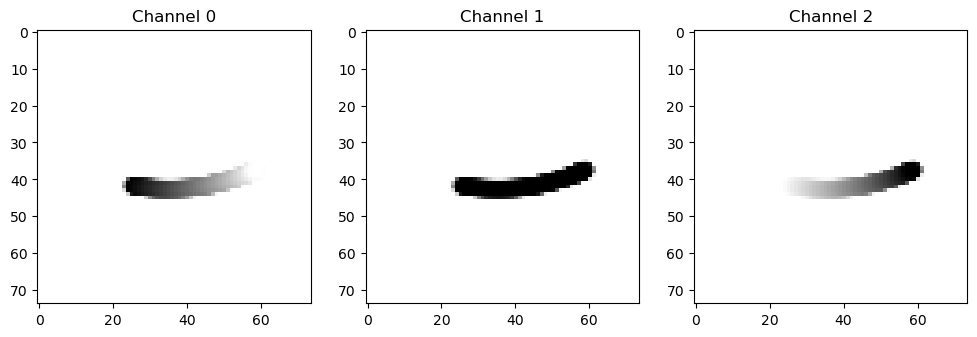

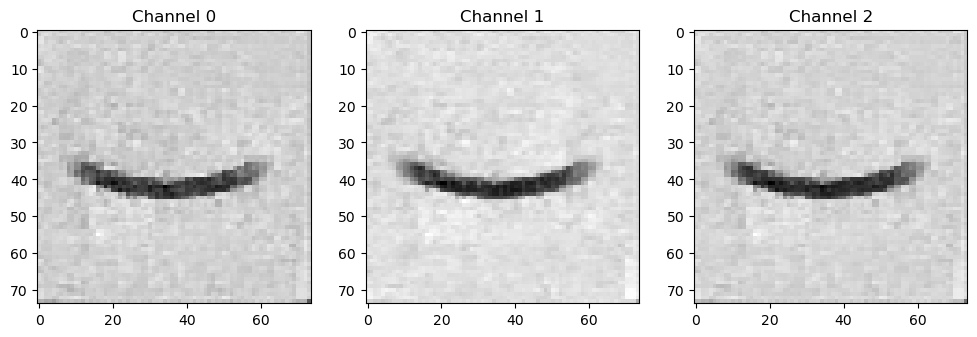

Epoch [57/200], Loss: 599.0411
Epoch [58/200], Loss: 576.8173
Epoch [59/200], Loss: 575.5710
Epoch [60/200], Loss: 583.4285
Epoch [61/200], Loss: 583.5228


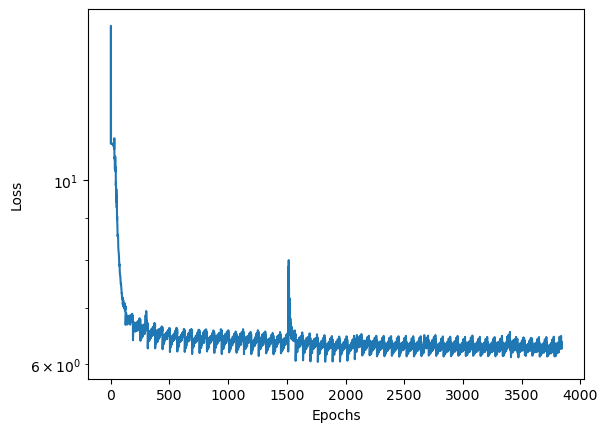

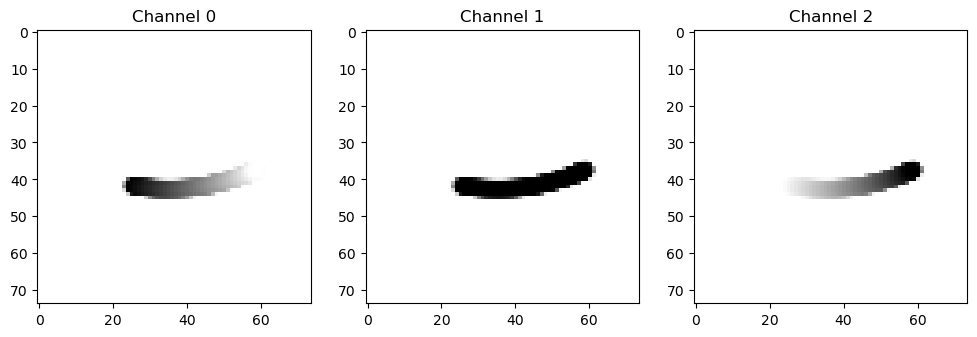

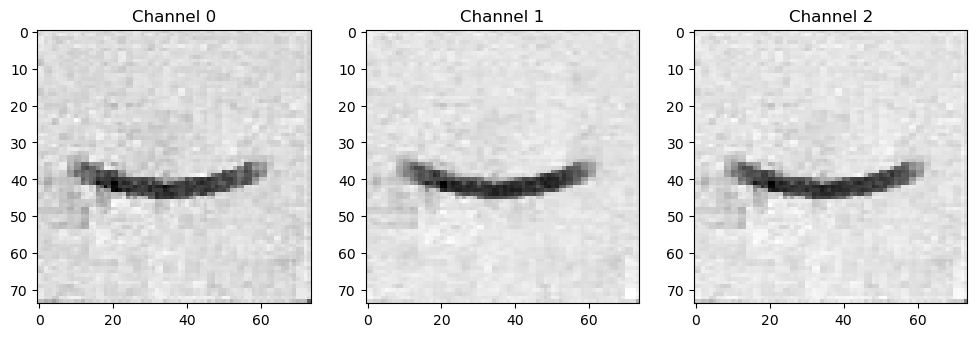

Epoch [62/200], Loss: 556.9898
Epoch [63/200], Loss: 564.5191
Epoch [64/200], Loss: 562.6284
Epoch [65/200], Loss: 587.5569
Epoch [66/200], Loss: 593.8575


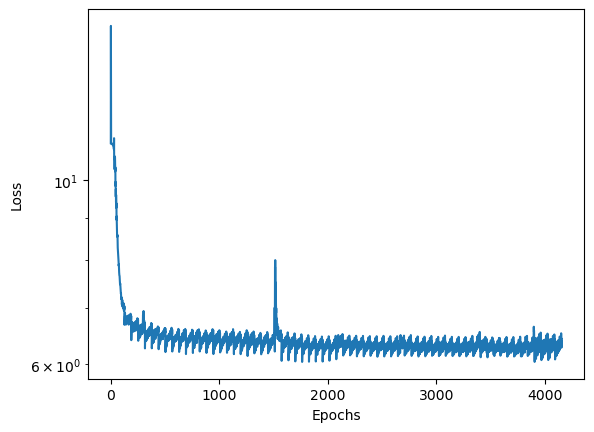

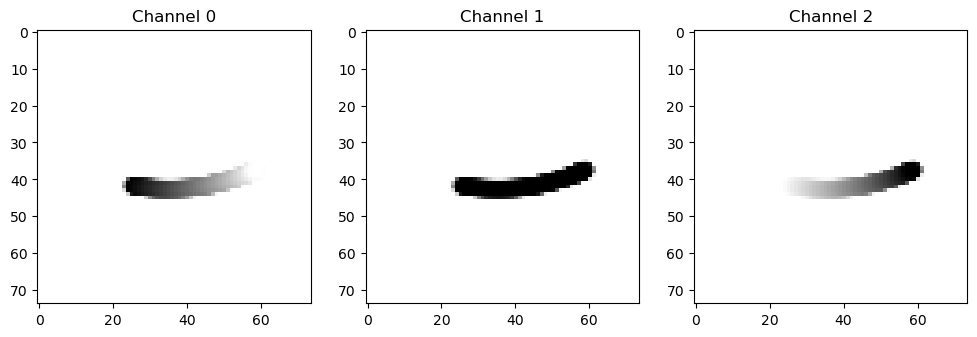

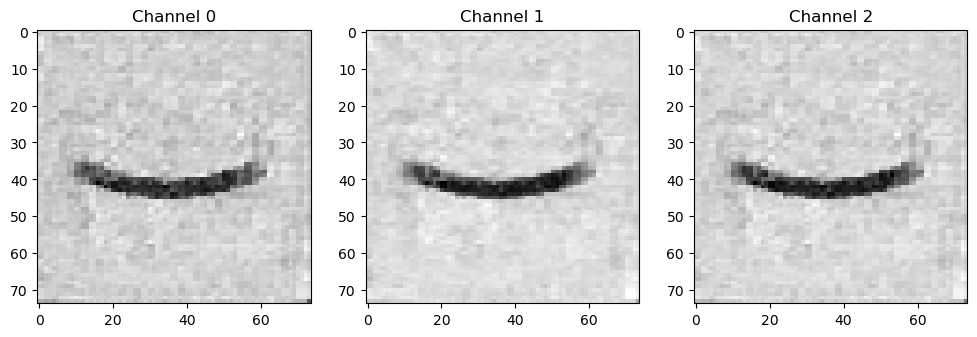

Epoch [67/200], Loss: 567.8107
Epoch [68/200], Loss: 565.8896
Epoch [69/200], Loss: 569.5427
Epoch [70/200], Loss: 565.4603
Epoch [71/200], Loss: 565.5171


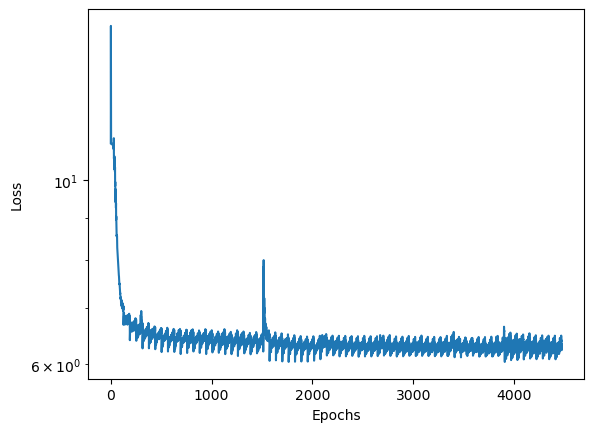

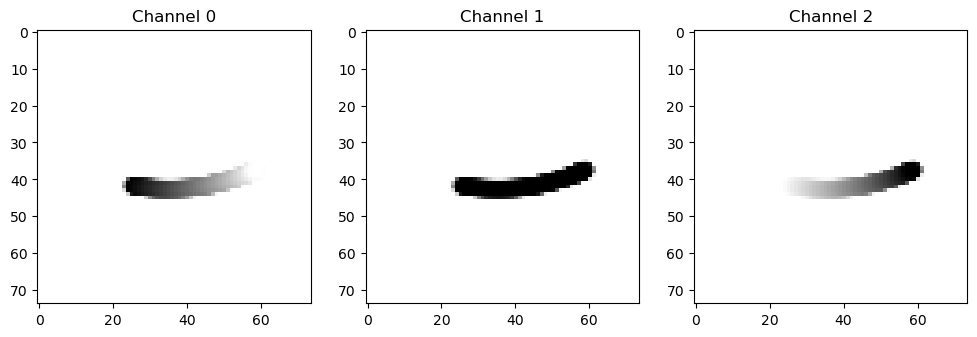

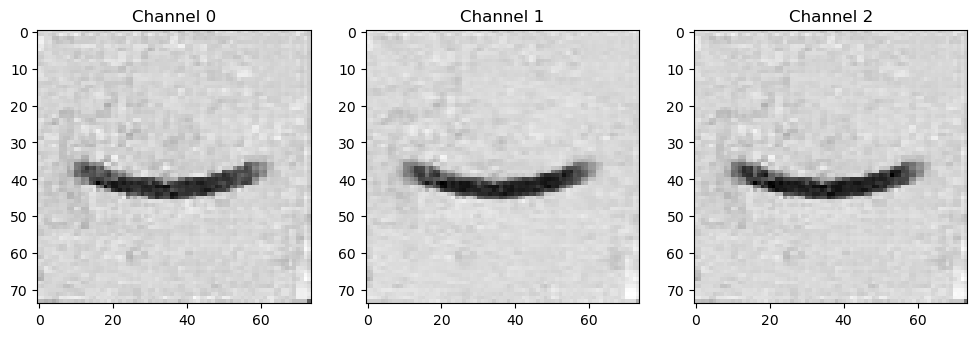

Epoch [72/200], Loss: 565.3783
Epoch [73/200], Loss: 567.2313
Epoch [74/200], Loss: 566.1824
Epoch [75/200], Loss: 566.8062
Epoch [76/200], Loss: 564.1609


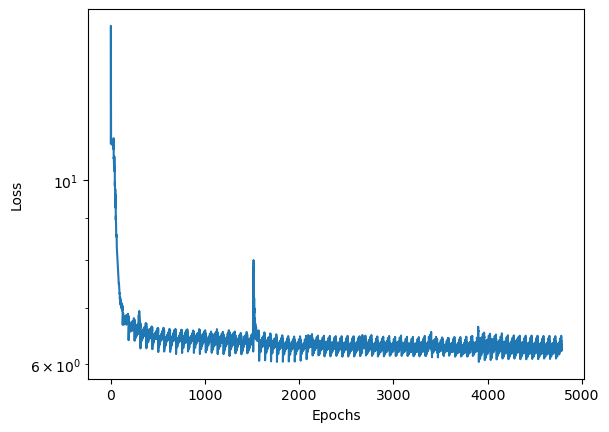

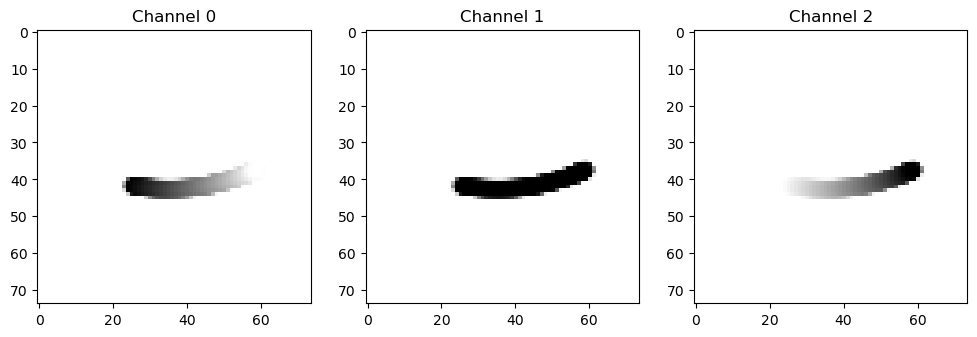

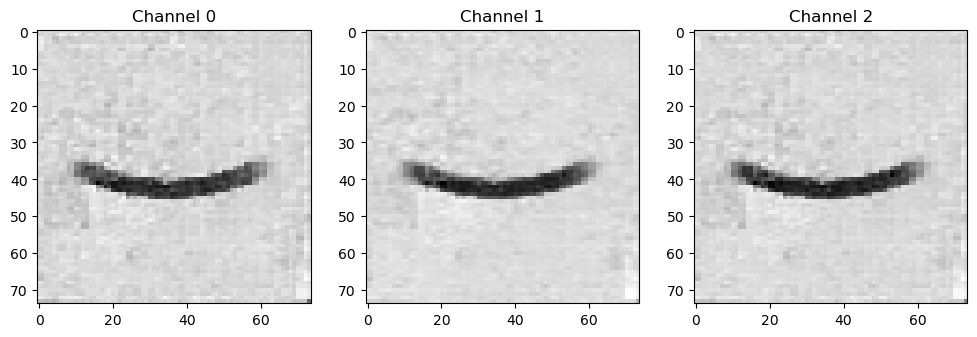

Epoch [77/200], Loss: 574.4789
Epoch [78/200], Loss: 563.8562
Epoch [79/200], Loss: 564.7710
Epoch [80/200], Loss: 567.8729
Epoch [81/200], Loss: 563.2657


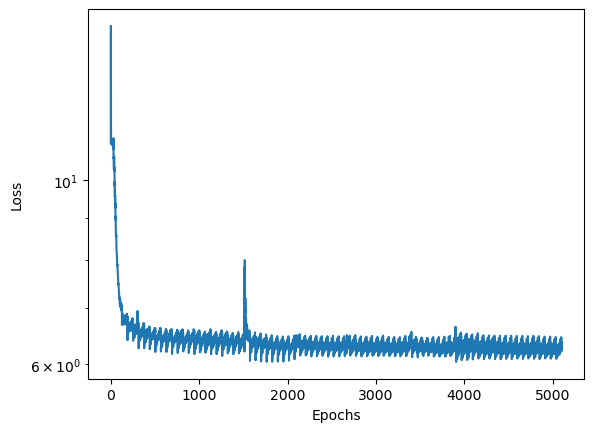

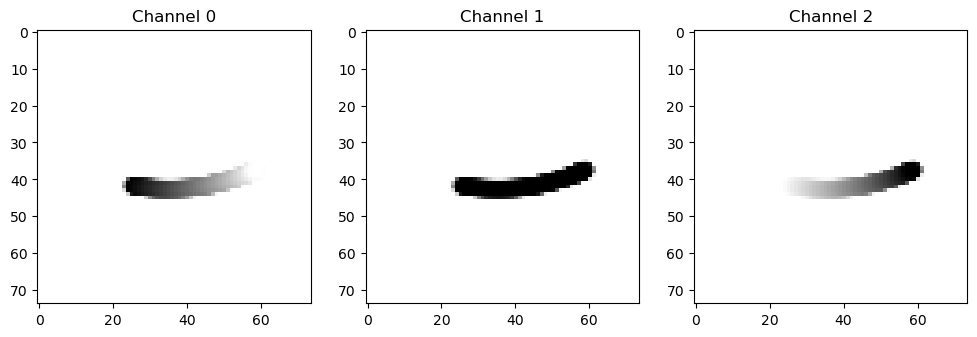

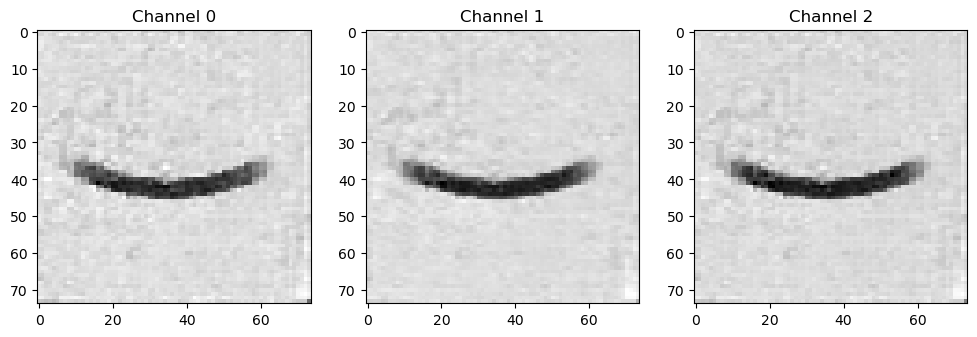

Epoch [82/200], Loss: 580.9816
Epoch [83/200], Loss: 568.4323
Epoch [84/200], Loss: 569.1530
Epoch [85/200], Loss: 567.6141
Epoch [86/200], Loss: 574.1445


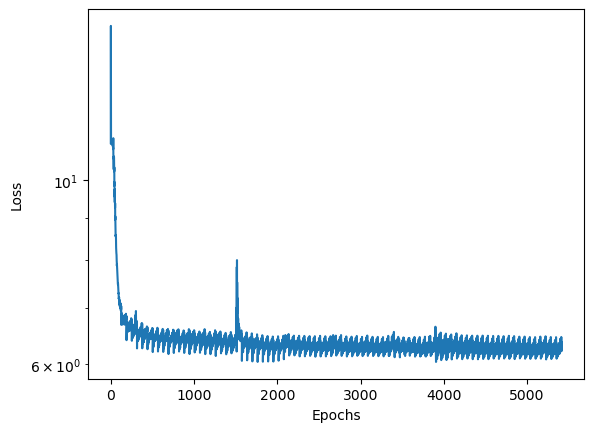

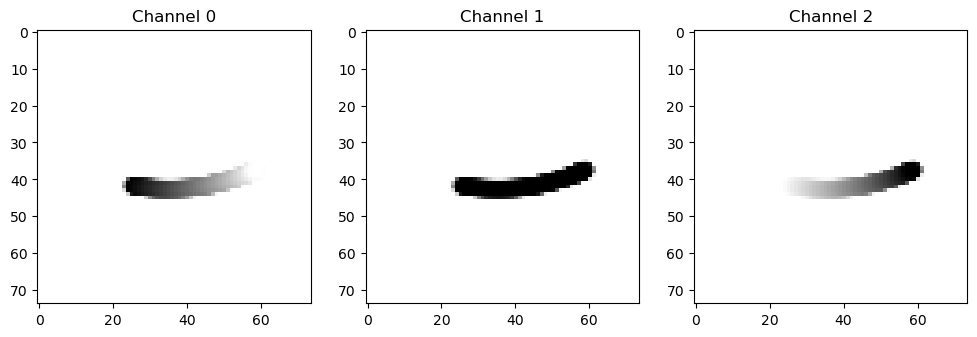

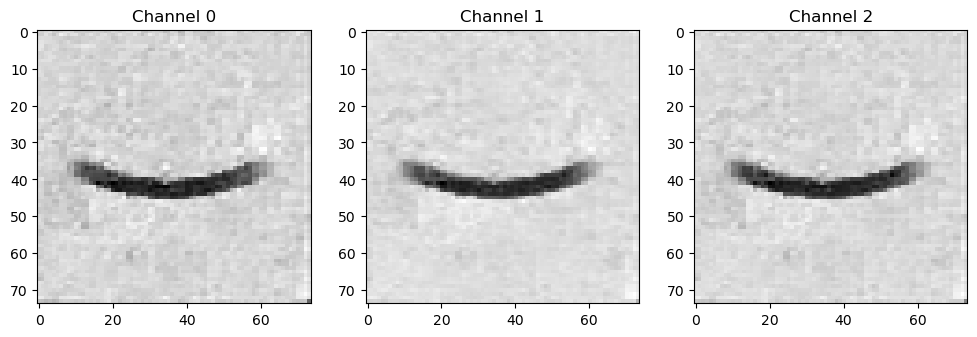

Epoch [87/200], Loss: 567.9649
Epoch [88/200], Loss: 566.6907
Epoch [89/200], Loss: 569.8188
Epoch [90/200], Loss: 569.4043
Epoch [91/200], Loss: 574.9523


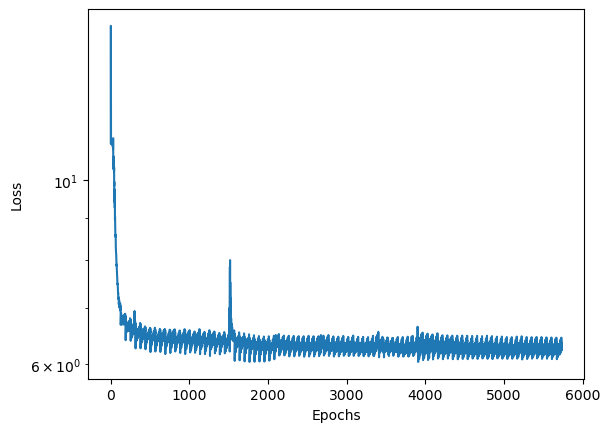

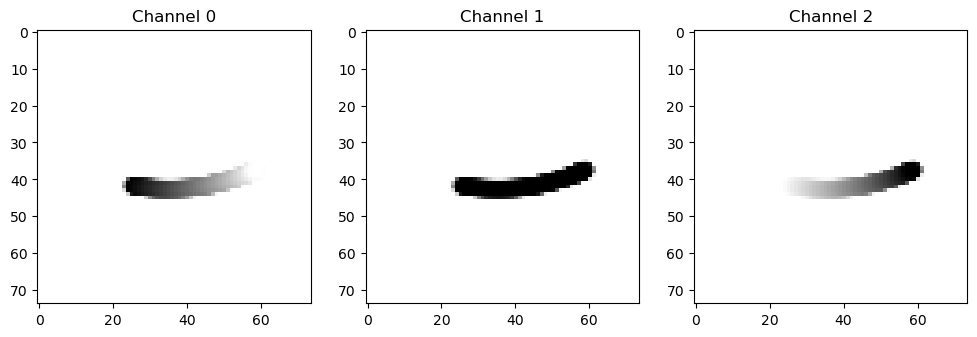

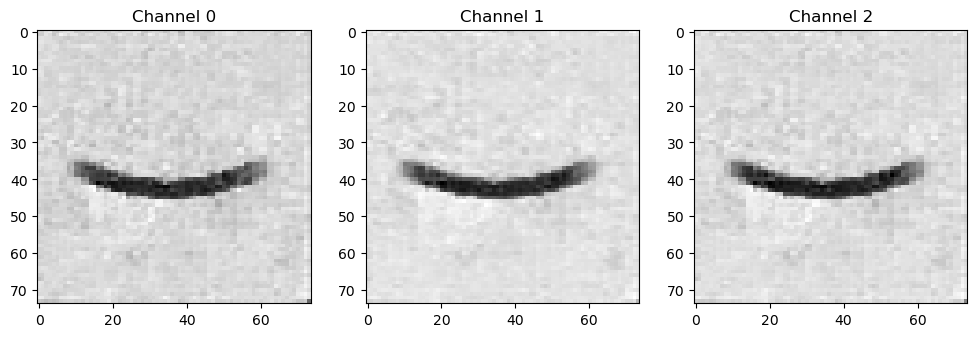

Epoch [92/200], Loss: 571.7972
Epoch [93/200], Loss: 567.0652
Epoch [94/200], Loss: 580.6315
Epoch [95/200], Loss: 592.6785
Epoch [96/200], Loss: 564.7548


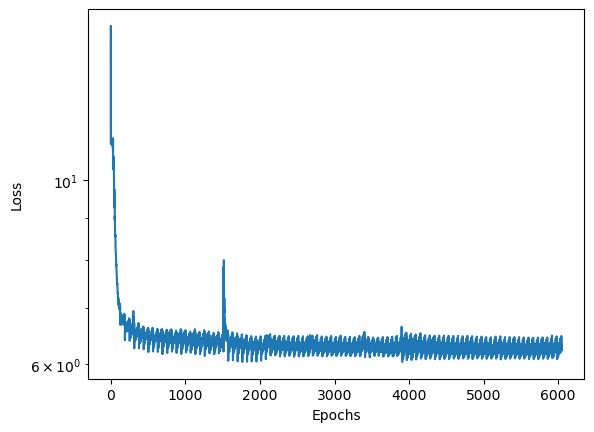

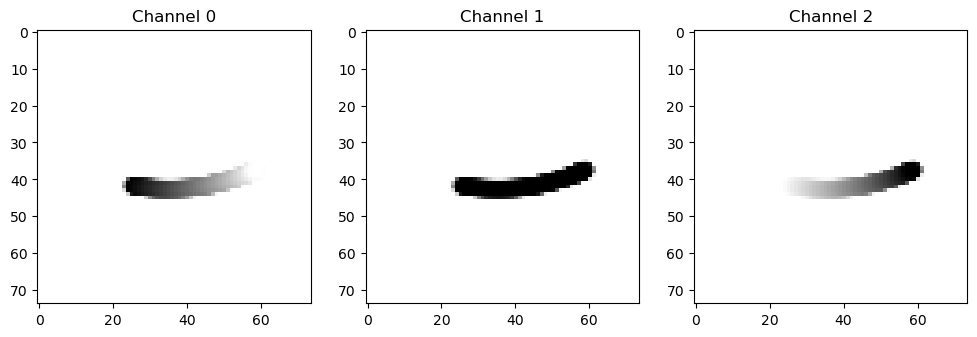

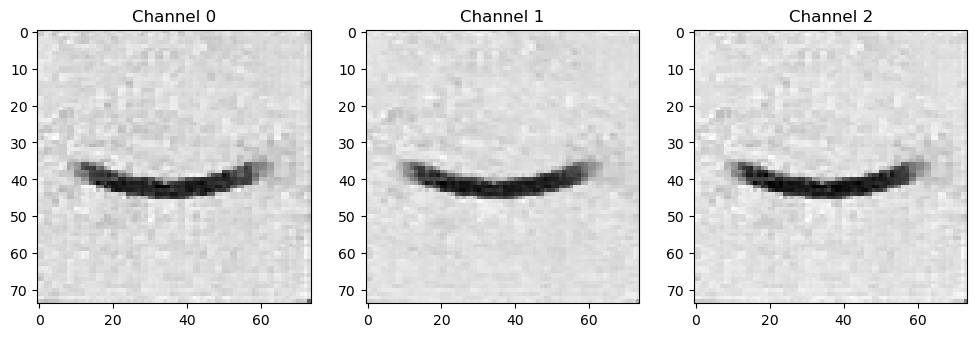

Epoch [97/200], Loss: 573.7173
Epoch [98/200], Loss: 632.6008


KeyboardInterrupt: 

In [13]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-1
num_epochs = 200

# Example: frames_matrices = np.random.rand(10000, 387, 385, 3)

# Create DataLoader
dataset = CustomDataset(frames_matrices)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Initialize the autoencoder model and loss function
#model = Autoencoder(input_shape=np.shape(matrix[:,:,0:3]))
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

LOSS = []
# Training loop
for epoch in range(num_epochs):
    for data in dataloader:
        #img = data
        img = data.permute(0, 3, 1, 2)  # Change the order of dimensions for Conv2d input
        recon_img = model(img)
        loss = criterion(recon_img, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        LOSS.append(loss.cpu().detach().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if ((epoch)%20) ==0:    
        plt.plot(np.log(LOSS))
        plt.yscale('log')
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.show()    
        plot_input(img)
        plot_output(recon_img)

# Save the trained model
tc.save(model.state_dict(), 'autoencoder.pth')
